# Step #1 Loading the Data

In [2]:
# Tested with Python 3.8.8, Matplotlib 3.5, Seaborn 0.11.1, numpy 1.19.5, plotly 4.1.1, cufflinks 0.17.3, prophet 1.1.1, CmdStan 2.31.0

import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from math import log, exp 
from datetime import date, timedelta, datetime
import seaborn as sns
sns.set_style('white', {'axes.spines.right': False, 'axes.spines.top': False})
from scipy.stats import norm
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
import cmdstanpy
# cmdstanpy.install_cmdstan()
# cmdstanpy.install_cmdstan(compiler=True)

# Setting the timeframe for the data extraction
end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'

# Getting quotes
stockname = 'ETH-USD'
symbol = 'ETH-USD'

# You can either use webreader or yfinance to load the data from yahoo finance
# import pandas_datareader as webreader
# df = webreader.DataReader(symbol, start=start_date, end=end_date, data_source="yahoo")

import yfinance as yf #Alternative package if webreader does not work: pip install yfinance
df = yf.download(symbol, start=start_date, end=end_date)

# Quick overview of dataset
print(df.head())

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2017-11-09  308.644989  329.451996  307.056000  320.884003  320.884003   
2017-11-10  320.670990  324.717987  294.541992  299.252991  299.252991   
2017-11-11  298.585999  319.453003  298.191986  314.681000  314.681000   
2017-11-12  314.690002  319.153015  298.513000  307.907990  307.907990   
2017-11-13  307.024994  328.415009  307.024994  316.716003  316.716003   

                Volume  
Date                    
2017-11-09   893249984  
2017-11-10   885985984  
2017-11-11   842300992  
2017-11-12  1613479936  
2017-11-13  1041889984  


<AxesSubplot: xlabel='Date', ylabel='Close'>

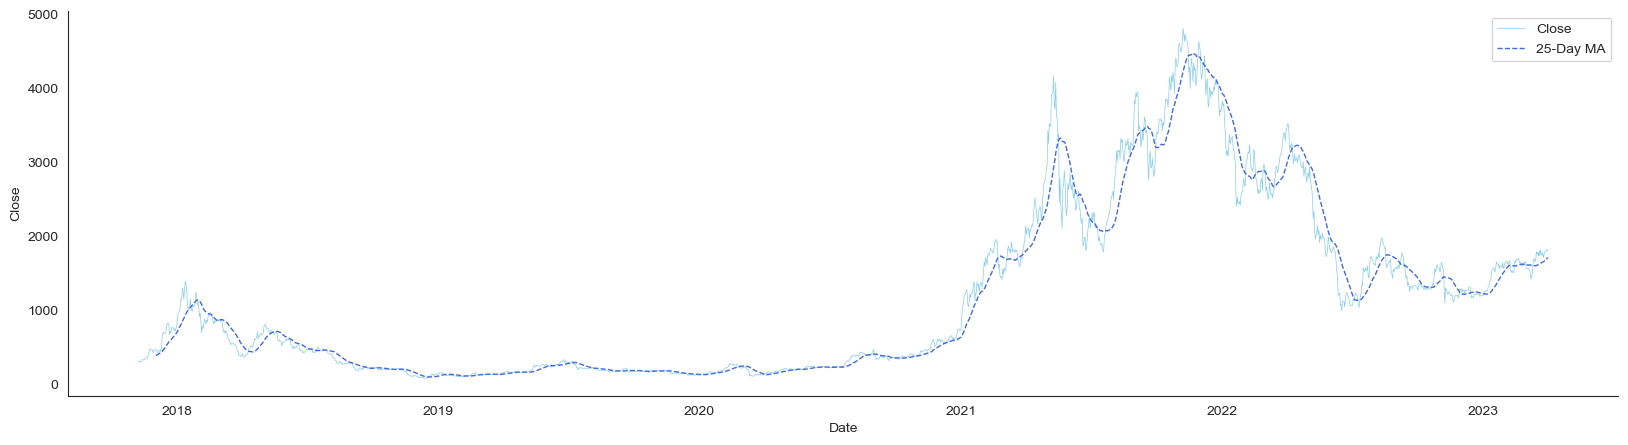

In [3]:
# Visualize the original time series
rolling_window=25
y_a_add_ma = df['Close'].rolling(window=rolling_window).mean() 

fig, ax = plt.subplots(figsize=(20,5))
sns.lineplot(data=df, x=df.index, y='Close', color='skyblue', linewidth=0.5, label='Close')
sns.lineplot(data=df, x=df.index, y=y_a_add_ma, 
    linewidth=1.0, color='royalblue', linestyle='--', label=f'{rolling_window}-Day MA')

# Step #2 Prepare the Data

In [4]:
df_x = df[['Close']].copy()
df_x['ds'] = df.index.copy()
df_x.rename(columns={'Close': 'y'}, inplace=True)
df_x.reset_index(inplace=True, drop=True)
df_x.dropna(inplace=True)
df_x.tail(3)

,y,ds
1968,1822.022095,2023-03-31
1969,1813.860596,2023-04-01
1970,1795.708130,2023-04-02


# Step #3 Model Training and Forecasting

In [5]:
# This function fits the prophet model to the input data and generates a forecast
def fit_and_forecast(df, periods, interval_width, changepoint_range=0.8):

    # set the uncertainty interval
    Prophet(interval_width=interval_width)
    # Instantiate the model
    model = Prophet(changepoint_range=changepoint_range)

    # Fit the model
    model.fit(df)

    # Create a dataframe with a given number of dates
    future_df = model.make_future_dataframe(periods=periods)

    # Generate a forecast for the given dates
    forecast_df = model.predict(future_df)
    #print(forecast_df.head())
    return forecast_df, model, future_df


# Forecast for 365 days with full data
forecast_df, model, future_df = fit_and_forecast(df_x, 365, 0.95)
print(forecast_df.columns)
forecast_df[['yhat_lower', 'yhat_upper', 'yhat']].head(5)

09:53:48 - cmdstanpy - INFO - Chain [1] start processing
09:53:49 - cmdstanpy - INFO - Chain [1] done processing


Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


,yhat_lower,yhat_upper,yhat
0,307.270026,1064.620215,690.019449
1,311.202140,1033.671910,679.510366
2,305.945773,1030.754046,677.151922
3,325.579184,1041.883258,672.728548
4,296.444960,1034.767584,664.125829


# Step #4 Analyzing the Forecast

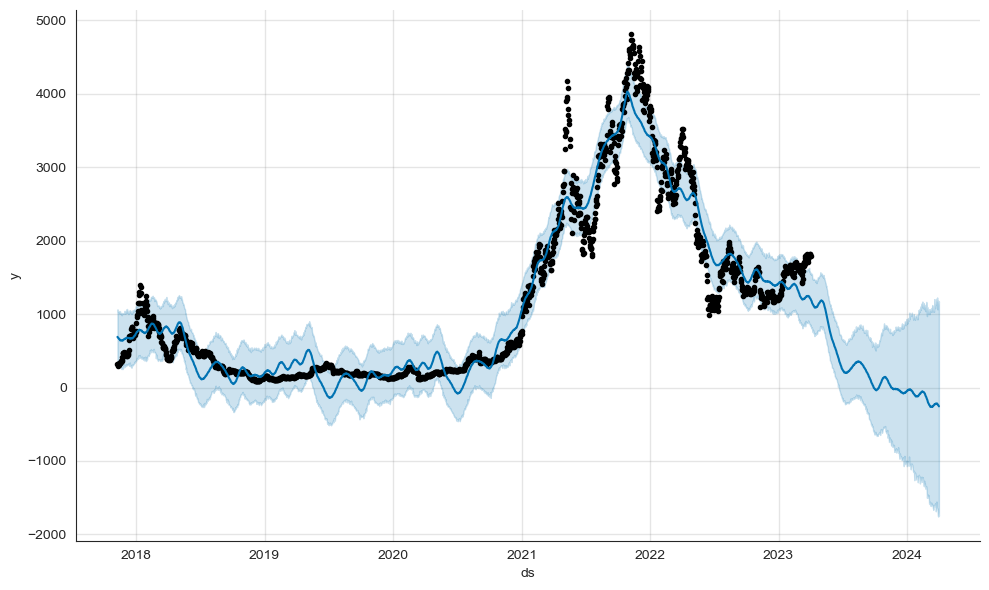

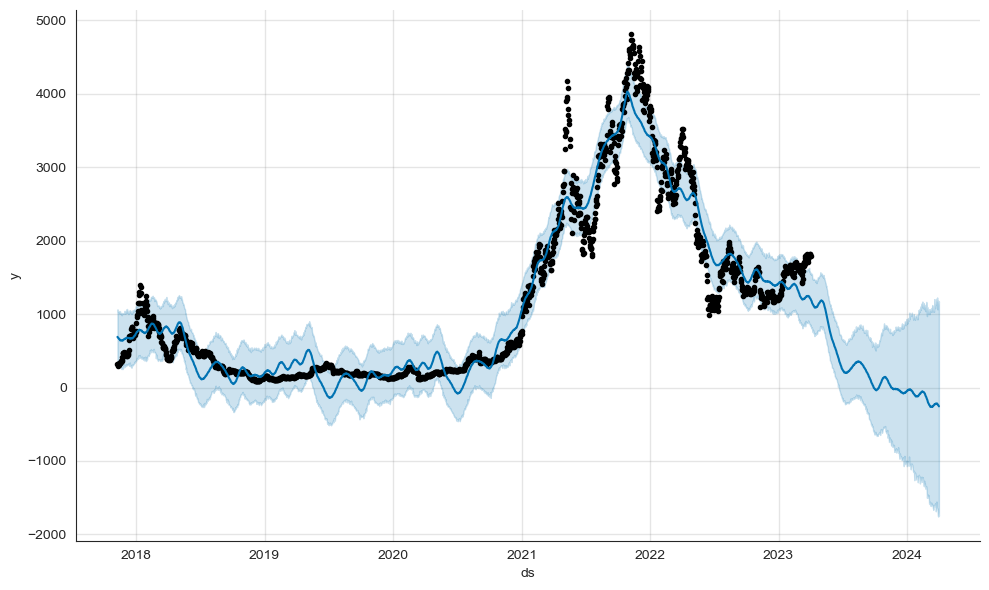

In [6]:
model.plot(forecast_df, uncertainty=True)

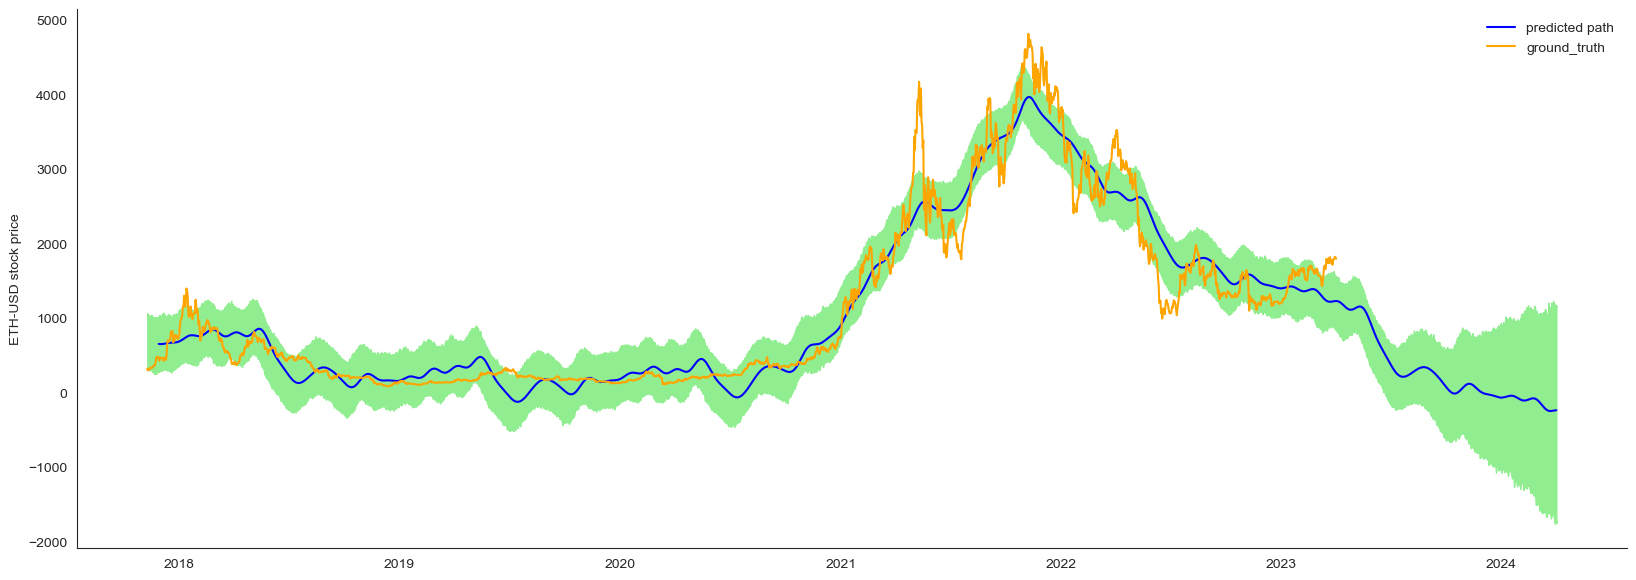

In [7]:
# Visualize the Forecast
def visualize_the_forecast(df_f, df_o):
    rolling_window = 20
    yhat_mean = df_f['yhat'].rolling(window=rolling_window).mean() 

    # Thin out the ground truth data for illustration purposes
    df_lim = df_o
    # Print the Forecast
    fig, ax = plt.subplots(figsize=[20,7])
    sns.lineplot(data=df_f, x=df_f.ds, y=yhat_mean, ax=ax, label='predicted path', color='blue')
    sns.lineplot(data=df_lim, x=df_lim.ds, y='y', ax=ax, label='ground_truth', color='orange')
    #sns.lineplot(data=df_f, x=df_f.ds, y='yhat_lower', ax=ax, label='yhat_lower', color='skyblue', linewidth=1.0)
    #sns.lineplot(data=df_f, x=df_f.ds, y='yhat_upper', ax=ax, label='yhat_upper', color='coral', linewidth=1.0)
    plt.fill_between(df_f.ds, df_f.yhat_lower, df_f.yhat_upper, color='lightgreen')
    plt.legend(framealpha=0)
    ax.set(ylabel=stockname + " stock price")
    ax.set(xlabel=None)

visualize_the_forecast(forecast_df, df_x)

# Step #5 Analyzing Model Components

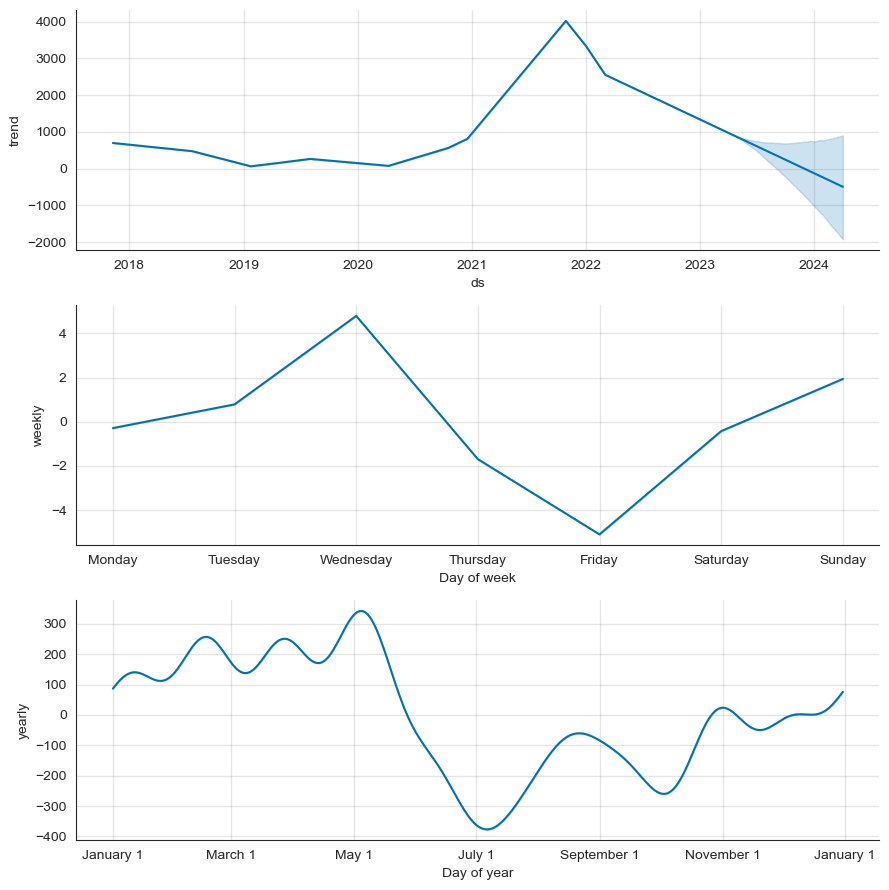

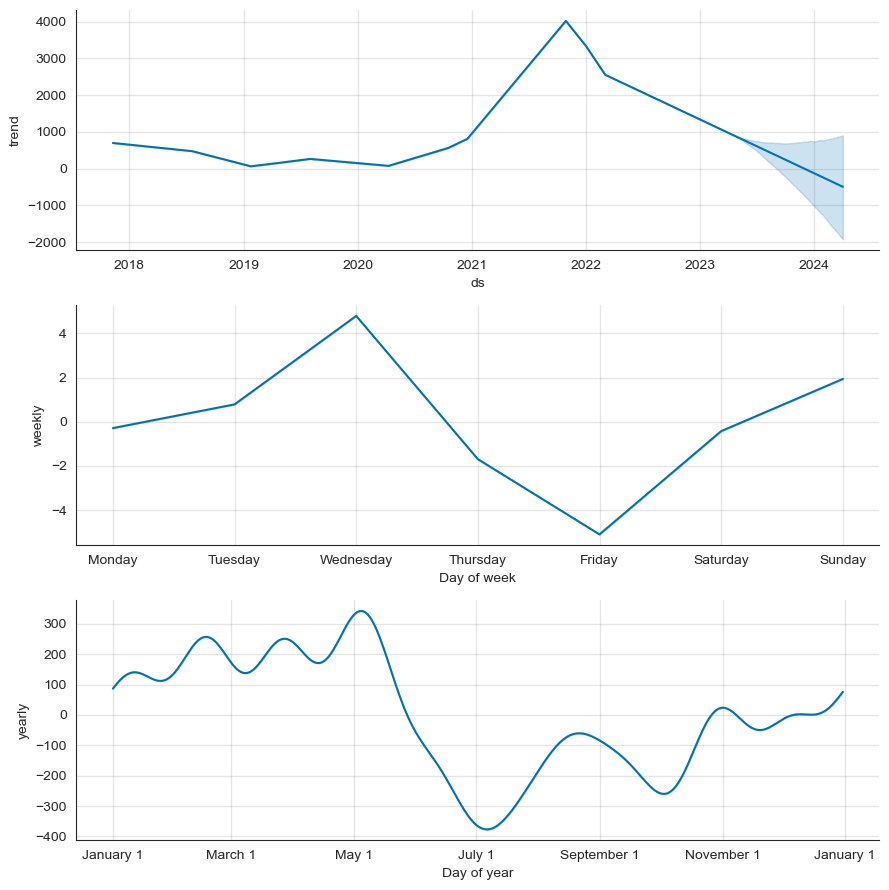

In [8]:
model.plot_components(forecast_df, True, weekly_start=1)

# Step #6 Adjusting the Changepoints of our Prophet Model

09:53:52 - cmdstanpy - INFO - Chain [1] start processing
09:53:52 - cmdstanpy - INFO - Chain [1] done processing


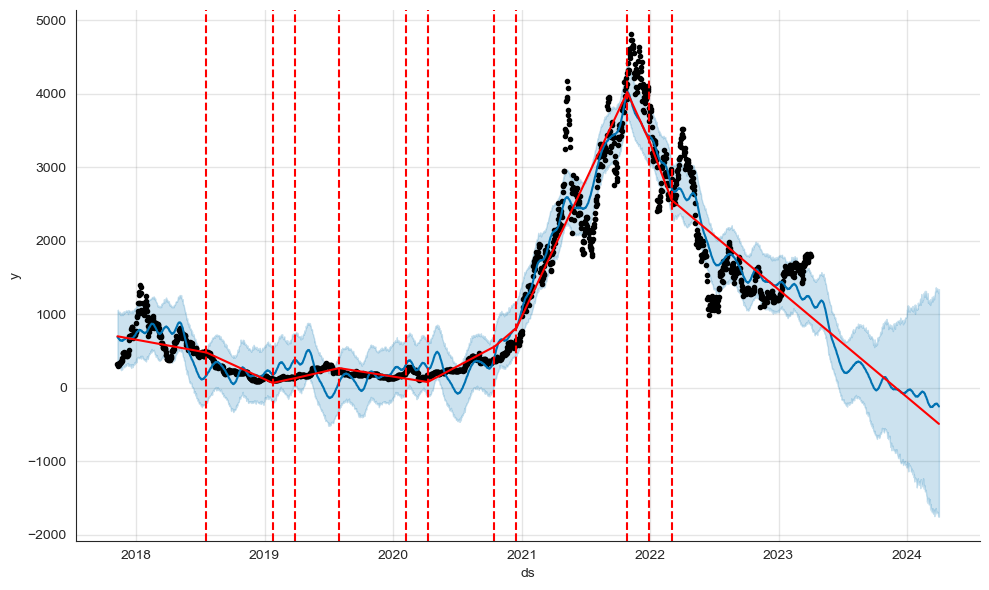

In [9]:
# Printing the ChangePoints of our Model
forecast_df, model, future_df = fit_and_forecast(df_x, 365, 1.0)
axislist = add_changepoints_to_plot(model.plot(forecast_df).gca(), model, forecast_df)

09:53:53 - cmdstanpy - INFO - Chain [1] start processing
09:53:54 - cmdstanpy - INFO - Chain [1] done processing


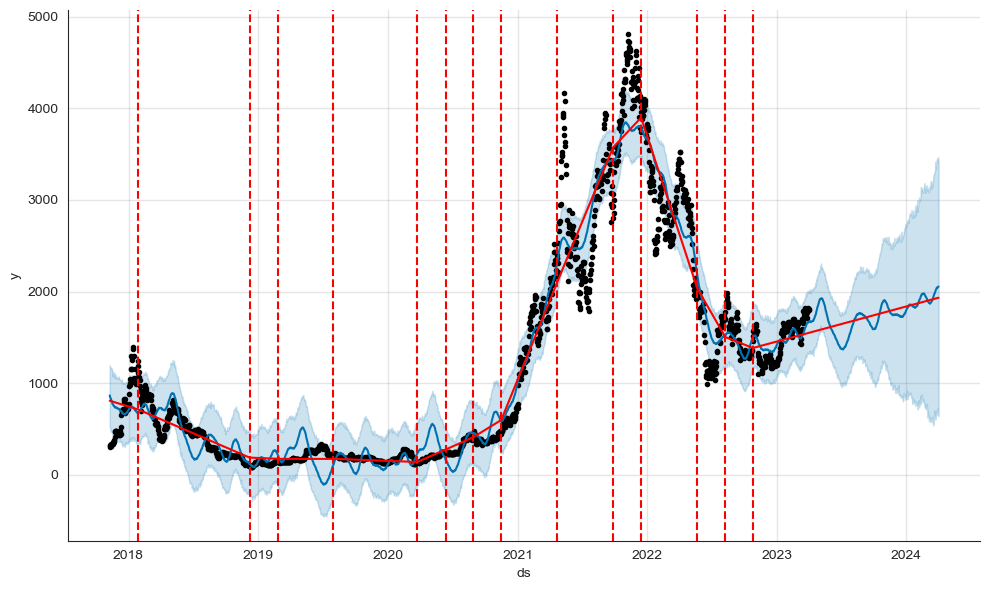

In [10]:
# Adjusting ChangePoints of our Model
forecast_df, model, future_df = fit_and_forecast(df_x, 365, 1.0, 1.0)
axislist = add_changepoints_to_plot(model.plot(forecast_df).gca(), model, forecast_df)